In [1]:
# ==================================================================================================
# Copyright (c) 2023 Ford Motor Company
#
# This code was developed by Praveen Kumar Reddy Kamasani as part of his research conducted at Dr.Guoyu Lu's Lab 
# at the University of Georgia, in collaboration with Ford Motor Company.
#
# For queries or further information, please contact:
# Praveen Kumar Reddy Kamasani
# Email: praveenkumarreddykamasani@gmail.com
# ==================================================================================================

# Below code is the version 2 of our attempt to calculate the absolute depth of the flat surface area of the image 
# by using the camera intrinsic and extrinsic parameters of the camera. In this version, we corrected the camera 
# calibration details using the LiDAR measurements

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import Counter
import os

### Step 1: Initialization of File Paths for KITTI Dataset Sample

Please specify the file paths for processing a sample image from the KITTI dataset:
 - rgb_image_path: Path to the KITTI dataset's sample RGB image.
 - calib_dir_path: Path to the directory containing calibration files for the KITTI dataset.
 - velo_file_path: Path to the sample LiDAR (Velodyne) data file from the KITTI dataset.
 - seg_image_path: Path to the sample semantic segmentation image from the KITTI dataset.

These paths are required for loading and processing the dataset's sample images and sensor data.

In [3]:
rgb_image_path="/mnt/data4TbExt4/praveen_projects_data/Road Supervised Depth/kitti_data/2011_09_29/2011_09_29_drive_0071_sync/image_02/data/0000000727.png"
calib_dir_path="/mnt/data4TbExt4/praveen_projects_data/Road Supervised Depth/kitti_data/2011_09_29/"
velo_file_path="/mnt/data4TbExt4/praveen_projects_data/Road Supervised Depth/kitti_data/2011_09_29/2011_09_29_drive_0071_sync/velodyne_points/data/0000000727.bin"
seg_image_path="/mnt/data4TbExt4/praveen_projects_data/Road Supervised Depth/semantic_maps/2011_09_29/2011_09_29_drive_0071_sync/image_02/0000000727.png"

#### Visualizing the Sample RGB Image

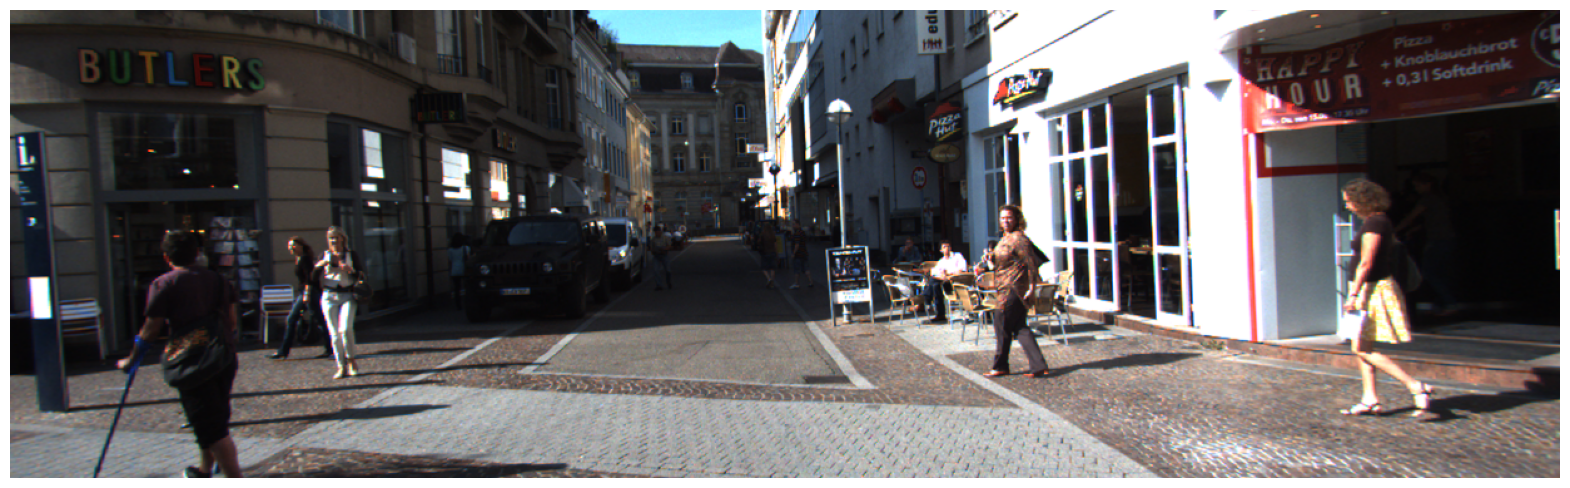

In [4]:
# Load the image
image_path = rgb_image_path
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the color image
fig, ax = plt.subplots(figsize=(20, 20))
plt.imshow(image)
plt.axis('off')
plt.show()

#### Semantic Segmented Map of the Full Image

Full Semantic Segmented Image: 


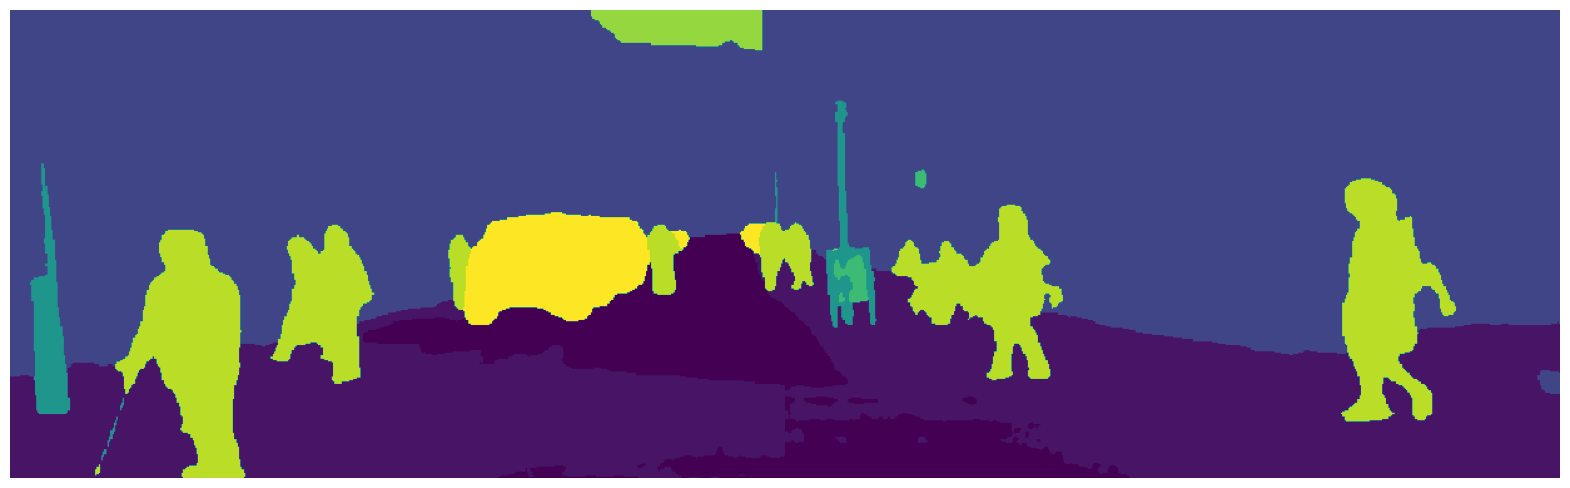

In [5]:
print("Full Semantic Segmented Image: ")

#Load Image
image_path = seg_image_path
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
#Resize
new_size = (1238, 374) 
resized_image = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)
# Display the masked color image
fig, ax = plt.subplots(figsize=(20, 20))
plt.imshow(resized_image)
plt.axis('off')
plt.show()

#### Semantic segmented map filtered for flat surface labels

Flat Surface Segmented Image: 


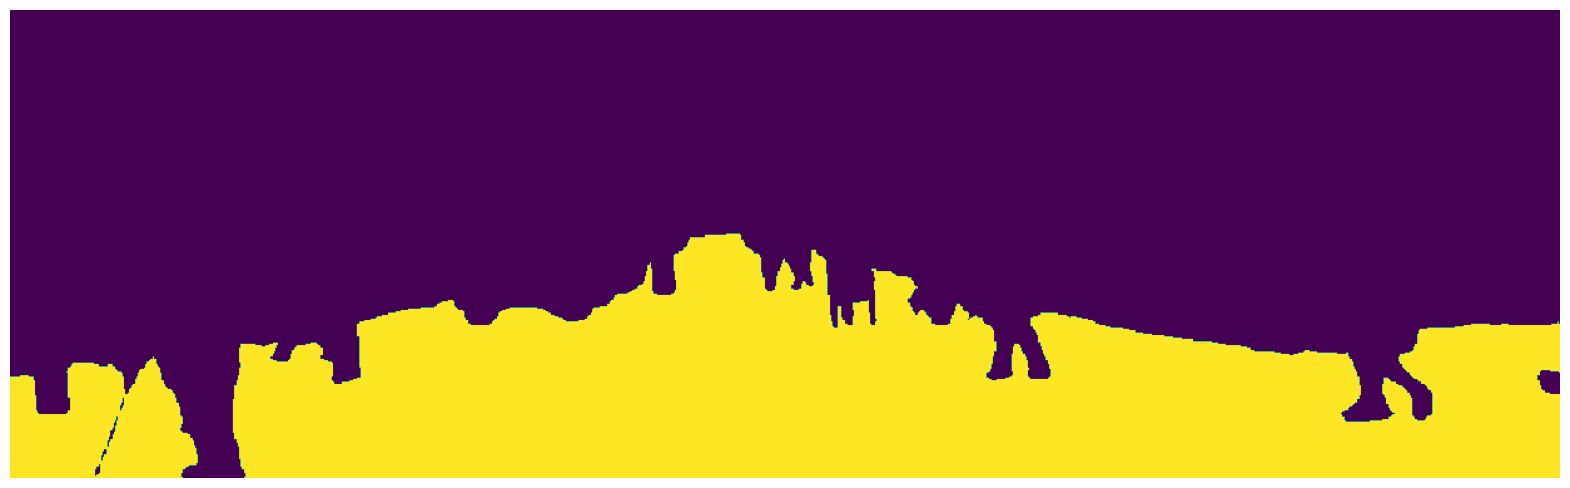

In [6]:
print("Flat Surface Segmented Image: ")
ground_labels = [6, 7, 8, 9, 10, 22]
# Create a masked image where all values except ground_labels are set to 0
Sem_gray_image_road = np.where(np.isin(resized_image, ground_labels), 7, 0)
# Display the masked color image
fig, ax = plt.subplots(figsize=(20, 20))
plt.imshow(Sem_gray_image_road)
plt.axis('off')
plt.show()

### Step 2: Generating Depth Map in Camera Coordinate System Using LiDAR Measurements

The following code segment is dedicated to calculating the depth map in the camera's coordinate system.
This is achieved by utilizing:
   - LiDAR measurements: Raw data points captured by the LiDAR sensor.
   - Calibration details: Information that aligns the LiDAR data with the camera's coordinate system.

The resultant depth map serves as a 'ground truth' reference. It is used for comparing and validating the physics-based depth map calculated later in this notebook. This comparison is crucial for ensuring the accuracy and reliability of camera-based depth perception in autonomous vehicle systems or similar applications.

In [7]:
def load_velodyne_points(filename):
    """
    Load 3D point cloud from KITTI file format
    (adapted from https://github.com/hunse/kitti)
    """
    points = np.fromfile(filename, dtype=np.float32).reshape(-1, 4)
    points[:, 3] = 1.0  # homogeneous
    return points

def read_calib_file(path):
    """
    Read KITTI calibration file
    (from https://github.com/hunse/kitti)
    """
    float_chars = set("0123456789.e+- ")
    data = {}
    with open(path, 'r') as f:
        for line in f.readlines():
            key, value = line.split(':', 1)
            value = value.strip()
            data[key] = value
            if float_chars.issuperset(value):
                # try to cast to float array
                try:
                    data[key] = np.array(list(map(float, value.split(' '))))
                except ValueError:
                    # casting error: data[key] already eq. value, so pass
                    pass
    return data

def sub2ind(matrixSize, rowSub, colSub):
    """Convert row, col matrix subscripts to linear indices
    """
    m, n = matrixSize
    return rowSub * (n - 1) + colSub - 1

def generate_depth_map(calib_dir, velo_filename, cam=2, vel_depth=False):
    """
    Generate a depth map from velodyne data
    """
    # load calibration files
    cam2cam = read_calib_file(os.path.join(calib_dir, 'calib_cam_to_cam.txt'))
    velo2cam = read_calib_file(os.path.join(calib_dir, 'calib_velo_to_cam.txt'))
    velo2cam = np.hstack((velo2cam['R'].reshape(3, 3), velo2cam['T'][..., np.newaxis]))
    velo2cam = np.vstack((velo2cam, np.array([0, 0, 0, 1.0])))

    # get image shape
    im_shape = cam2cam["S_rect_02"][::-1].astype(np.int32)

    # compute projection matrix velodyne->image plane
    R_cam2rect = np.eye(4)
    R_cam2rect[:3, :3] = cam2cam['R_rect_00'].reshape(3, 3)
    P_rect = cam2cam['P_rect_0' + str(cam)].reshape(3, 4)
    P_velo2im = np.dot(np.dot(P_rect, R_cam2rect), velo2cam)

    # load velodyne points and remove all behind image plane (approximation)
    # each row of the velodyne data is forward, left, up, reflectance
    velo = load_velodyne_points(velo_filename)
    velo = velo[velo[:, 0] >= 0, :]

    # project the points to the camera
    velo_pts_im = np.dot(P_velo2im, velo.T).T
    velo_pts_im[:, :2] = velo_pts_im[:, :2] / velo_pts_im[:, 2][..., np.newaxis]

    if vel_depth:
        velo_pts_im[:, 2] = velo[:, 0]

    # check if in bounds
    # use minus 1 to get the exact same value as KITTI matlab code
    velo_pts_im[:, 0] = np.round(velo_pts_im[:, 0]) - 1
    velo_pts_im[:, 1] = np.round(velo_pts_im[:, 1]) - 1
    val_inds = (velo_pts_im[:, 0] >= 0) & (velo_pts_im[:, 1] >= 0)
    val_inds = val_inds & (velo_pts_im[:, 0] < im_shape[1]) & (velo_pts_im[:, 1] < im_shape[0])
    velo_pts_im = velo_pts_im[val_inds, :]

    # project to image
    depth = np.zeros((im_shape[:2]))
    depth[velo_pts_im[:, 1].astype(np.int), velo_pts_im[:, 0].astype(np.int)] = velo_pts_im[:, 2]

    # find the duplicate points and choose the closest depth
    inds = sub2ind(depth.shape, velo_pts_im[:, 1], velo_pts_im[:, 0])
    dupe_inds = [item for item, count in Counter(inds).items() if count > 1]
    for dd in dupe_inds:
        pts = np.where(inds == dd)[0]
        x_loc = int(velo_pts_im[pts[0], 0])
        y_loc = int(velo_pts_im[pts[0], 1])

        depth[y_loc, x_loc] = velo_pts_im[pts, 2].min()
    depth[depth < 0] = 0
    return depth

In [8]:
velodyne_depth_map_full_image = generate_depth_map(calib_dir=calib_dir_path, velo_filename=velo_file_path)

/home/pk11519/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


#### Visualizing the above LiDAR's depth map in camera coordinate system

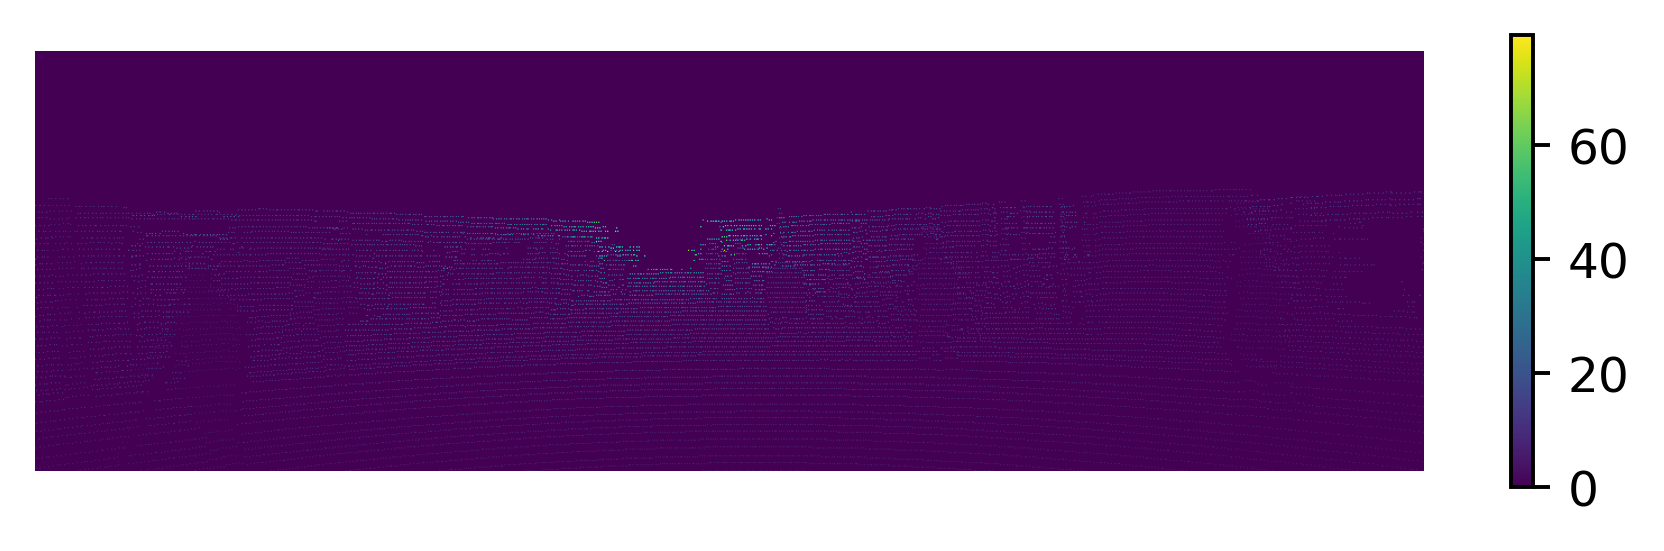

Shape:  (374, 1238)
Min Depth:  0.0
Max Depth:  79.37269078446835
Max Depth:  0.5662281255711784


In [9]:
# Visualization
fig = plt.figure(dpi=350)
plt.axis('off')
plt.imshow(velodyne_depth_map_full_image)
plt.colorbar(shrink=0.35)
plt.show()

# Additional Details
print("Shape: ", velodyne_depth_map_full_image.shape)
print("Min Depth: ", velodyne_depth_map_full_image.min())
print("Max Depth: ", velodyne_depth_map_full_image.max())
print("Max Depth: ", velodyne_depth_map_full_image.mean())

#### LiDAR's depth map of flat surface in camera coordinate system

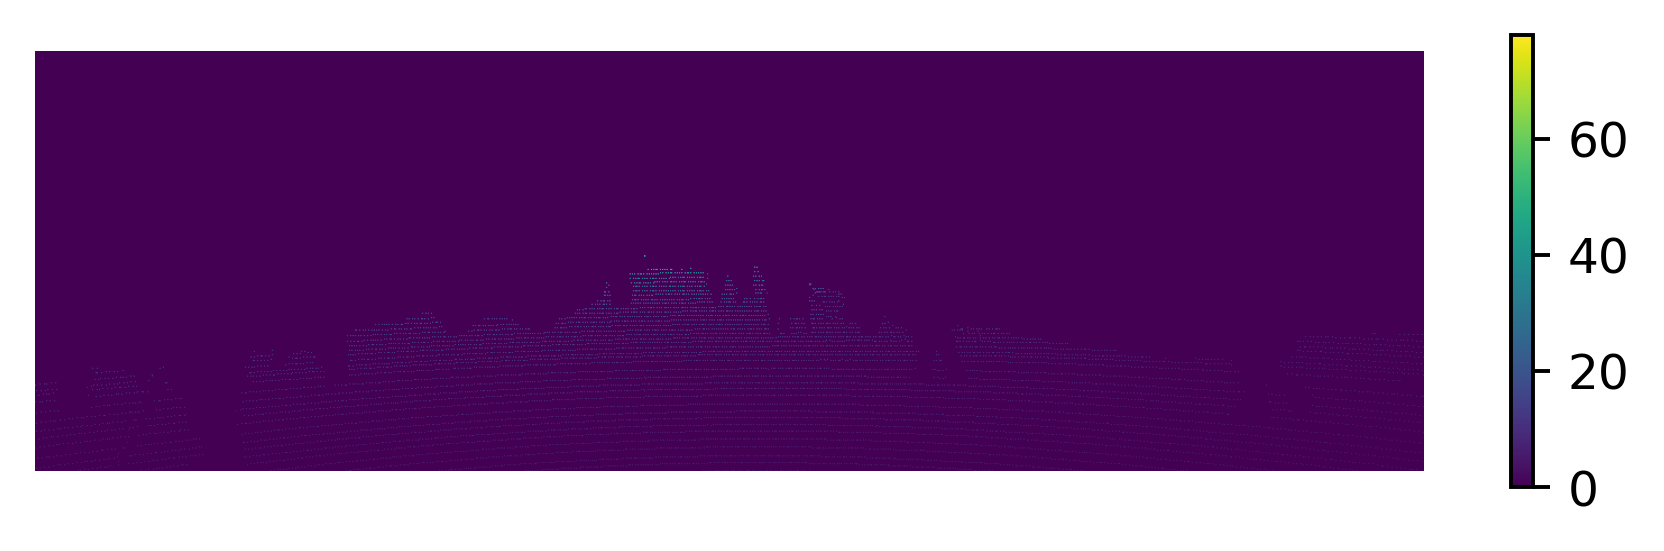

In [10]:
# Perform the pixel-wise operation to make non-road pixels depth and negative depth as 0
velodyne_depth_map_road=velodyne_depth_map_full_image.copy()

for i in range(Sem_gray_image_road.shape[0]):
    for j in range(Sem_gray_image_road.shape[1]):
        if Sem_gray_image_road[i, j] != 7 or velodyne_depth_map_full_image[i, j] < 0:
            velodyne_depth_map_road[i, j] = 0

fig = plt.figure(dpi=350)
plt.axis('off')
plt.imshow(velodyne_depth_map_road)
plt.colorbar(shrink=0.35)
plt.show()

### Step 3 : Calculation of Physics Depth Map

In the below code, we calculate the physics depth map of the whole image using the camera calibration details adjusted using the LiDAR measurements

In [11]:
# estimate ground surface orientation from lidar point
# ground surface orientation estimate:
# n_x*(x-x0) + n_y*(y-y0) + n_z*(z-z0) = 0;

#get lidar 3d points
def depthToPt3d(d, x, y, f):
    r = np.array([x,y,f]) # ISO coordinate
    unit_r = r / np.linalg.norm(r)
    return d*r

# Rectified Image Dimensions
height = 374
width = 1238

# Extract Fx, Fy, Cx, and Cy
Fx = 7.183351e+02
Fy = 7.183351e+02

Cx = int(np.floor(6.003891e+02))
Cy = int(np.floor(1.815122e+02))

f = (Fx + Fy) / 2

# Create a depth array
map3d_f = np.zeros((3, height*width))

# Calculate depth for each pixel
idx = 0
for y in range(height):
    for x in range(width):
        x_custom = x - Cx
        y_custom = y - Cy
        d = velodyne_depth_map_road[y,x]
        if not d==0:
            map3d_f[:,idx] = depthToPt3d(d, x_custom, y_custom, f)
            idx = idx+1

map3d = np.delete(map3d_f,np.s_[idx:],axis = 1)
print(idx)
print(map3d.shape)

# centroid of 3D points:
centroid = map3d.mean(axis = 1)

print(map3d.shape[1])

H = np.zeros((3, map3d.shape[1]));

# estimate surface normal:
for i in range(map3d.shape[1]):
    H[:,i] = map3d[:,i] - centroid;

A = np.dot(H,H.T)

U, S, Vh = np.linalg.svd(A, full_matrices=True)

N = U[:,2]

print("surface normal:")
print(N)

# decompose surface normal to roll, pitch angle
pitchAngle = np.arcsin(N[2])
rollAngle = -np.arcsin(N[0]/np.cos(pitchAngle))

print(rollAngle,pitchAngle)

R_roll = np.array([[np.cos(rollAngle), -np.sin(rollAngle),0],
                    [np.sin(rollAngle),np.cos(rollAngle),0],
                    [0, 0, 1]]);

R_pitch = np.array([[1, 0, 0],
                    [0, np.cos(pitchAngle), -np.sin(pitchAngle)],
                    [0, np.sin(pitchAngle), np.cos(pitchAngle)]]);

R_g2l= np.dot(R_roll,R_pitch)
R_l2g = R_g2l.T
pt_g =  np.dot(R_l2g,map3d)
centroid_g = pt_g.mean(axis = 1)
height_l2g = centroid_g[1]

print("Rotation to ground:")
print(R_l2g)

print("height to ground:")
print(height_l2g)

9393
(3, 9393)
9393
surface normal:
[0.04450482 0.99885344 0.01763861]
-0.044526454135144375 0.01763952013173021
Rotation to ground:
[[ 9.99008861e-01 -4.45117425e-02  0.00000000e+00]
 [ 4.45048177e-02  9.98853443e-01  1.76386054e-02]
 [-7.85125061e-04 -1.76211231e-02  9.99844428e-01]]
height to ground:
1190.8525388973396


Shape:  (374, 1238)
Min Depth:  -422313.8707
Max Depth:  2620715.5399


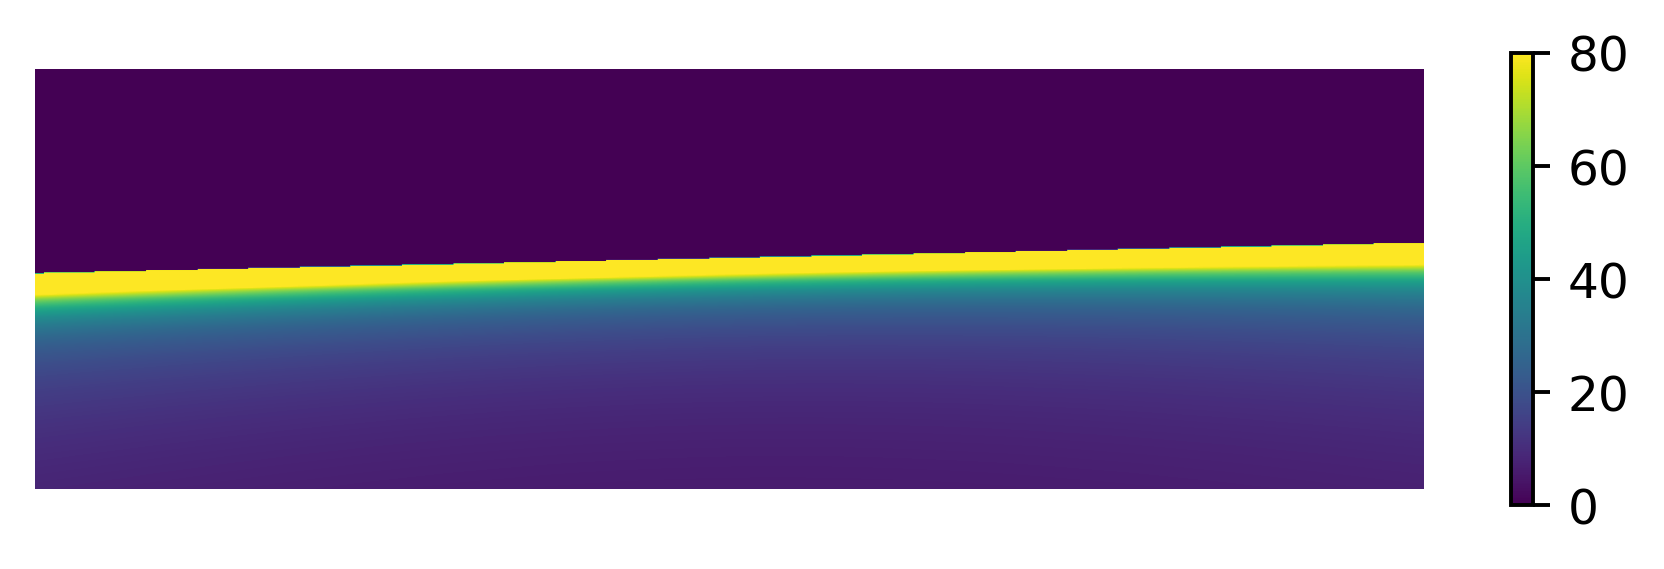

In [12]:
#S_rect_02: 1.238000e+03 3.740000e+02

#R_rect_02:
# 9.998896e-01 1.484154e-02 7.649204e-04 
#-1.484114e-02 9.998897e-01 -5.289052e-04 
#-7.726858e-04 5.174945e-04 9.999996e-01

#P_rect_02: 7.183351e+02 0.000000e+00 6.003891e+02 4.450382e+01 0.000000e+00 7.183351e+02 1.815122e+02 -5.951107e-01 0.000000e+00 0.000000e+00 1.000000e+00 2.616315e-03

# calib_velo_to_cam.txt
R_lidar2cam = np.array([[7.755449e-03, -9.999694e-01, -1.014303e-03],
                        [2.294056e-03, 1.032122e-03, -9.999968e-01],
                        [9.999673e-01, 7.753097e-03, 2.301990e-03]])

R_img2iso = np.array([[0,-1, 0],[0, 0,-1],[1, 0, 0]]);
R_c2l = np.dot(R_img2iso.T,R_lidar2cam)

import numpy as np
import matplotlib.pyplot as plt
import cv2

# Rectified Image Dimensions
height = 374
width = 1238

# Create the R matrix
R_c02c2 = np.array([
    [ 9.998896e-01, 1.484154e-02,  7.649204e-04], 
    [-1.484114e-02, 9.998897e-01, -5.289052e-04], 
    [-7.726858e-04, 5.174945e-04,  9.999996e-01]
])

# rotation from camera 2 to ground = R_c02c2*R_c02l*R_l2g
R = np.dot(R_c02c2,np.dot(R_c2l,R_l2g))

# Function to calculate road depth
def road_depth(x, y):
    f = (Fx + Fy) / 2
    r = np.array([x, y, f])
    unit_r = r / np.linalg.norm(r)
    rc = np.matmul(R, unit_r)
    d = 1.65 / rc[1]
    return round(d, 4)

# Create a depth array
depth_array = np.zeros((1, height, width))

# Calculate depth for each pixel
for y in range(height):
    for x in range(width):
        x_custom = x - Cx 
        y_custom = y - Cy
        depth_array[0, y, x] = road_depth(x_custom, y_custom)

phy_depth_map_full_image= depth_array[0]

# Display
print("Shape: ", phy_depth_map_full_image.shape)
print("Min Depth: ", phy_depth_map_full_image.min())
print("Max Depth: ",phy_depth_map_full_image.max())

image = np.clip(phy_depth_map_full_image, 0.0000, 80) # Clipping just for visualization
fig = plt.figure(dpi=350)
plt.axis('off')
plt.imshow(image)  
plt.colorbar(shrink=0.35)
plt.show()

### Step 3 : Segmenting Physics Depth Map for Flat Surface

In the below code, we segment the physics depth map for the flat surface using the semantic segmented image.

#### Physics Depth Map of Flat Surface in camera coordinate system

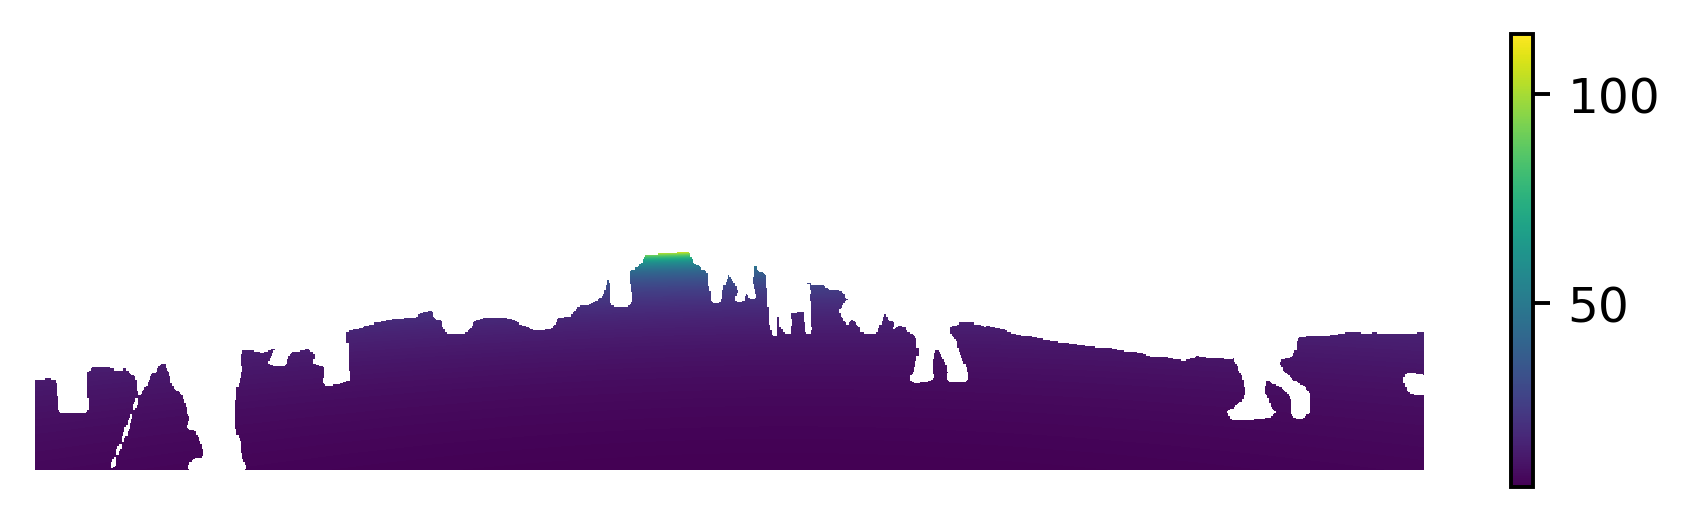

Depth Metrics: 
Shape:  (374, 1238)
Min Depth:  0.0
Max Depth:  114.2931
Mean Depth:  3.219000872763557


In [13]:
# Perform the pixel-wise operation to make non-road pixels depth and negative depth as 0
phy_depth_map_road=phy_depth_map_full_image.copy()

for i in range(Sem_gray_image_road.shape[0]):
    for j in range(Sem_gray_image_road.shape[1]):
        if Sem_gray_image_road[i, j] != 7 or phy_depth_map_full_image[i, j]< 0:
            phy_depth_map_road[i, j] = 0

# Masking zeros
masked_image = np.ma.masked_where((phy_depth_map_road == 0)|(phy_depth_map_road==0), phy_depth_map_road) # For Visualization Purpose

fig = plt.figure(dpi=350)
plt.axis('off')
plt.imshow(masked_image)
plt.colorbar(shrink=0.35)
plt.show()

# Display
print("Depth Metrics: ")
print("Shape: ", phy_depth_map_road.shape)
print("Min Depth: ", phy_depth_map_road.min())
print("Max Depth: ",phy_depth_map_road.max())
print("Mean Depth: ",phy_depth_map_road.mean())

### Step 4: Evaluation of Physics Depth Map

#### Percentage Error Distribution

Below is the pecentage error distribution of physics depth map when compared against LiDAR ground truth in camera coordinate system

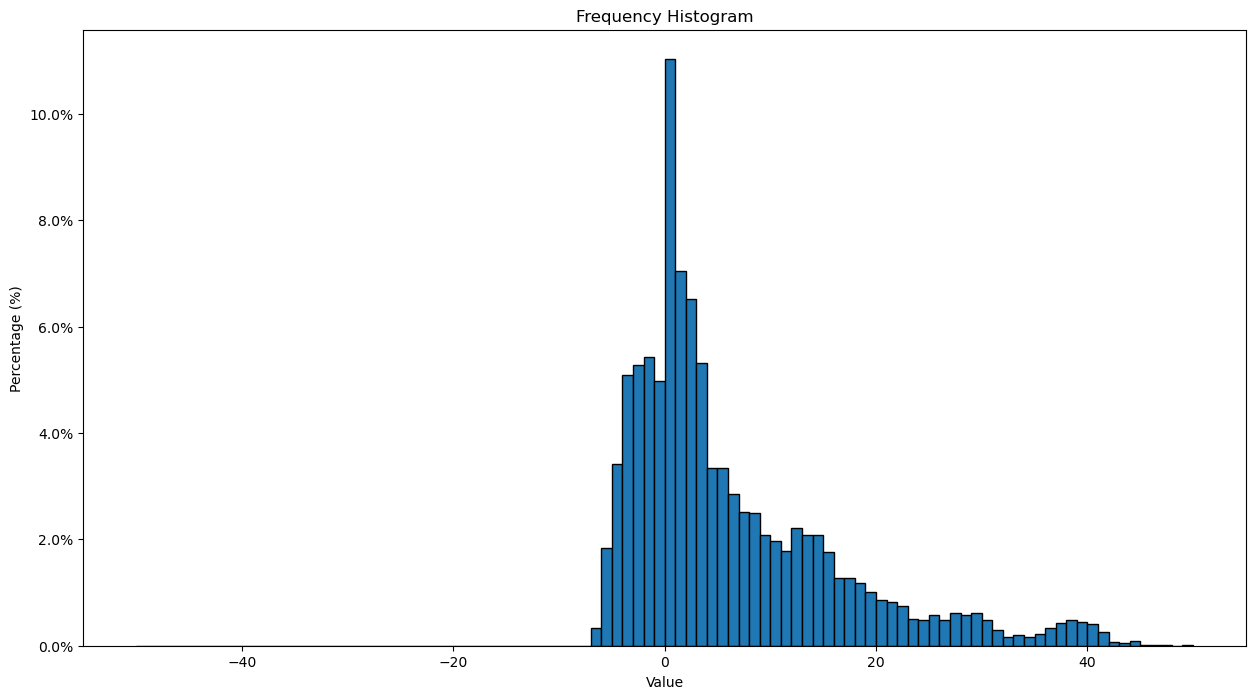

In [14]:
from collections import Counter

# Initialize frequency counter
freq_counter = Counter()

# Load Physics Depth
physics_depth_map = phy_depth_map_road
ld_depth_map = velodyne_depth_map_road

# Create an empty array with the same shape as the original depth maps
percentage_difference_map = np.zeros_like(ld_depth_map)

# Iterate over the depth maps
for i in range(ld_depth_map.shape[0]):
    for j in range(ld_depth_map.shape[1]):
        lidar_value = ld_depth_map[i, j]
        physics_value = physics_depth_map[i, j]

        # Check if either value is zero
        if lidar_value == 0 or physics_value == 0:
            percentage_difference = 0
        else:
            # Calculate the percentage difference and round to 2 decimals
            percentage_difference = round(((physics_value-lidar_value) / (physics_value)) * 100, 2)
            
        # Place the calculated value in the percentage difference map
        percentage_difference_map[i, j] = percentage_difference

# Flatten the array to work with 1D data
flattened_map = percentage_difference_map.flatten()
# Filter out zero values
non_zero_values = flattened_map[flattened_map != 0]

# Update frequency counter
for val in non_zero_values:
    if -50 < val < 50:
        freq_counter[int(val)] += 1

# Print and save frequency
total_count = sum(freq_counter.values())

for i in range(-50, 50):
    count = freq_counter.get(i, 0)
    #print(f"Range ({i}, {i+1}): {count} values")

# Plot histogram
plt.figure(figsize=(15, 8))  # Increase the size of the histogram
plt.hist(list(freq_counter.elements()), bins=range(-50, 51), edgecolor='black', density=True)

# Convert y-axis to percentage
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(xmax=1))

plt.xlabel('Value')
plt.ylabel('Percentage (%)')
plt.title('Frequency Histogram')
plt.show()

#### Percentage Error Map

Below is the pecentage error map of physics depth map when compared against LiDAR ground truth

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma

#Load Percentage Difference Map
percentage_difference_map = percentage_difference_map

# Mask the 0.00 values in the percentage_difference_map
masked_data = ma.masked_where(percentage_difference_map == 0, percentage_difference_map)

# Create a figure with a specific size
fig, ax = plt.subplots(figsize=(25, 5), dpi=1000)

# Plot the heatmap using the imshow function with a different colormap (e.g., 'viridis')
# Set the color scale limits with vmin and vmax
im = ax.imshow(masked_data, cmap='Dark2', interpolation='nearest', vmin=-20, vmax=25)

# Create a divider for the existing axes instance
divider = make_axes_locatable(ax)

# Append axes to the right of the main axes, with 20% width of the parent figure
cax = divider.append_axes("right", size="5%", pad=0.05)

# Add a colorbar to show the mapping of values to colors
plt.colorbar(im, cax=cax, label='Percentage Error')

# Add labels and title
ax.set_xlabel('Pixel X')
ax.set_ylabel('Pixel Y')
ax.set_title('Error Map: ((Phy-Lid)/Phy)*100')

# Show the plot
plt.show()